In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import torchvision   
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
import time
import torch.optim as optim
from torch.autograd import Variable
import os
import gdown
import zipfile
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

In [1]:
!pip3 install torch
!pip3 install torchvision
!pip3 install gdown

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 804.1 MB 1.4 kB/s s eta 0:00:01    |██████▌                         | 163.7 MB 68.4 MB/s eta 0:00:10
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 17.4 MB 40 kB/s s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.13.0-py3-none-any.whl size=9034 sha256=656bf2a79019dde35406944d13e2e8312fef0a4d

In [ ]:
# data download source is not shown due to fair use

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(use_cuda, device, torch.cuda.device_count())

False cpu 0


## Model

In [3]:
class MyBetaVAE(nn.Module):
    def __init__(self, in_channels, z_dim, beta): # image should have size 64*64
        super(MyBetaVAE, self).__init__()
        self.z_dim = z_dim
        self.beta = beta

        # hidden_dims = [in_channels, 32, 64, 128, 256, 512]
        hidden_dims = [in_channels, 32, 64, 128, 256]
        self.encoder_final_size = 16
        self.hidden_dims = hidden_dims

        # encoder
        encoder_layers = []
        for i in range(len(hidden_dims)-1):
            encoder_layers.append(nn.Sequential(
                                        nn.Conv2d(hidden_dims[i], hidden_dims[i+1], kernel_size=3, stride=2, padding=1),
                                        nn.BatchNorm2d(hidden_dims[i+1]),
                                        nn.LeakyReLU()
                                  ))
        
        self.encoder = nn.Sequential(*encoder_layers)
        self.mu = nn.Linear(hidden_dims[-1] * self.encoder_final_size, z_dim)
        self.logvar = nn.Linear(hidden_dims[-1] * self.encoder_final_size, z_dim)

        # decoder
        self.decoder_in = nn.Linear(z_dim, hidden_dims[-1] * self.encoder_final_size)

        decoder_layers = []
        for i in range(len(hidden_dims)-1, 0, -1):
            decoder_layers.append(nn.Sequential(
                                      nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i] if i == 1 else hidden_dims[i-1], kernel_size=3, stride=2, padding=1, output_padding=1),
                                      nn.BatchNorm2d(hidden_dims[i] if i == 1 else hidden_dims[i-1]),
                                      nn.LeakyReLU()
                                  ))
        
        self.decoder = nn.Sequential(*decoder_layers,
                                     nn.Conv2d(hidden_dims[1], hidden_dims[0], kernel_size=3, padding=1),
                                     nn.Sigmoid())
    
    def encode(self, x):
        out = self.encoder(x)
        out = torch.flatten(out, start_dim=1)
        mu = self.mu(out)
        logvar = self.logvar(out)
        self.mu_value = mu
        self.logvar_value = logvar
        self.x = x
        return mu, logvar
    
    def decode(self, x):
        out = self.decoder_in(x).view(-1, self.hidden_dims[-1], 4, 4)
        out = self.decoder(out)
        return out
    
    def reparam(self, mu, logvar):
        std = torch.exp(logvar / 2)
        epsilon = torch.autograd.Variable(torch.randn_like(std))
        return std * epsilon + mu


    def forward(self, x):
        time1 = time.time()
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        time2 = time.time()
        out = self.decode(z)
        time3 = time.time()
        self.x_cons = out
        return out, z, mu, logvar, Variable(torch.tensor(time2-time1)), Variable(torch.tensor(time3-time2)) #{"encodertime": , "decodertime": }
    
    def loss(self):
        reconstruction_loss = F.mse_loss(self.x_cons, self.x, reduction='sum')
        kl_div = torch.mean(torch.sum(-0.5 * (1 + self.logvar_value - self.mu_value ** 2 - self.logvar_value.exp()), dim=1), dim=0)
        return reconstruction_loss + self.beta * kl_div, reconstruction_loss, kl_div

In [4]:
class MyBetaVAEEncoder(MyBetaVAE):
    
    def __init__(self, in_channels, z_dim, beta): # image should have size 64*64
        super().__init__(in_channels, z_dim, beta)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        return z, mu, logvar

class MyBetaVAEDecoder(MyBetaVAE):
    
    def __init__(self, in_channels, z_dim, beta): # image should have size 64*64
        super().__init__(in_channels, z_dim, beta)
    
    def forward(self, z):
        out = self.decode(z)
        return out

## DataLoader

In [5]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor()                                              
])

def get_dataloaders(path, shuffle, portion, val_split, batch_size, test=False):
    dataset = torchvision.datasets.ImageFolder(root=path, transform=transforms)
    if test:
      test_dataset = torchvision.datasets.ImageFolder(root=path, transform=test_transforms)
      for filename in test_dataset.imgs:
          frame_names.append(filename[0].split('/')[-1])

    shuffle_dataset = shuffle
    use_proportion = portion
    validation_split = val_split
    batch_size = batch_size
    random_seed= 42

    # Creating data indices for training and validation splits:
    indices = list(range(len(dataset)))
    use_length = int(len(dataset) * use_proportion)
    split = int(np.floor((1 - validation_split) * len(dataset)) * use_proportion)
    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices = indices[:split]
    print(train_indices)
    val_indices = indices[split:use_length]
    print(len(train_indices), len(val_indices))
    print(len(dataset), use_length, split)

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
  

    train_dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True, sampler=train_sampler, num_workers=4)
    val_dataloader = DataLoader(dataset, batch_size=batch_size, drop_last=True, sampler=val_sampler, num_workers=4)

    if test:
      test_sampler = SequentialSampler(train_indices)
      test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=False, sampler=test_sampler, num_workers=4)
      return test_dataloader, test_dataloader
    

    return train_dataloader, val_dataloader

## Inference & Accuracy

In [6]:
!mkdir ./dev_data/

In [7]:
!unzip ./unique-142p-valid.zip
!mv ./unique-142p-valid ./dev_data/unique-142p-valid

Archive:  ./unique-142p-valid.zip
   creating: unique-142p-valid/
  inflating: __MACOSX/._unique-142p-valid  
  inflating: unique-142p-valid/frame_005292.png  
  inflating: __MACOSX/unique-142p-valid/._frame_005292.png  
  inflating: unique-142p-valid/frame_025142.png  
  inflating: __MACOSX/unique-142p-valid/._frame_025142.png  
  inflating: unique-142p-valid/frame_012936.png  
  inflating: __MACOSX/unique-142p-valid/._frame_012936.png  
  inflating: unique-142p-valid/frame_021324.png  
  inflating: __MACOSX/unique-142p-valid/._frame_021324.png  
  inflating: unique-142p-valid/frame_011581.png  
  inflating: __MACOSX/unique-142p-valid/._frame_011581.png  
  inflating: unique-142p-valid/frame_010847.png  
  inflating: __MACOSX/unique-142p-valid/._frame_010847.png  
  inflating: unique-142p-valid/frame_021442.png  
  inflating: __MACOSX/unique-142p-valid/._frame_021442.png  
  inflating: unique-142p-valid/frame_003185.png  
  inflating: __MACOSX/unique-142p-valid/._frame_003185.png  
  

In [6]:
import torch
import torchvision
import matplotlib.pyplot as plt

logs = {}
avg_loss = 0
z_ls = []
batch_size = 512 # 2048, 1024, 512, 256

frame_names = []
dev_loader, dev_original_loader = get_dataloaders('./dev_data', shuffle=False, portion=1, val_split=0, batch_size=batch_size, test=True)
print(frame_names)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [7]:
import numpy as np
labels = np.genfromtxt('./scene-change.csv', delimiter=',', names=True, dtype=None, encoding=None)

In [8]:
len(labels)

259

In [9]:
label_ls = [] # record frame1 in true_labels
for labels in labels:
  label_ls.append(labels[0])
print(label_ls[:10])

['frame_001278.png', 'frame_001279.png', 'frame_001499.png', 'frame_001607.png', 'frame_001617.png', 'frame_001690.png', 'frame_001743.png', 'frame_001802.png', 'frame_001839.png', 'frame_001867.png']


In [10]:
# label for scene change 1 represent change
true_labels = []
for name in frame_names:
    if name in label_ls:
        true_labels.append(1)
    else:
        true_labels.append(0)
print(len(true_labels))

12938


## Quantization

In [13]:
!mkdir models
!pip3 install onnx
!pip3 install onnxruntime
!pip3 install py-cpuinfo
!pip3 install torch-summary

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 12.2 MB 17.6 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 4.1 MB 15.3 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 99 kB 12.5 MB/s eta 0:00:01
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22245 sha256=db8544e7172ca95dad9df250e7391eacc9655b6873b2

In [11]:
# Model and Inference
import onnx
import onnx.numpy_helper
import onnxruntime
import onnxruntime.quantization

# Data Loader
import torch
import torchvision

# Evaluation
import numpy as np
import sklearn.metrics
from torchsummary import summary


# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Other Utilities
import os
import pandas as pd
from tqdm.notebook import tqdm
# import cpuinfo # !conda install -c conda-forge py-cpuinfo # not used in colab
import cpuinfo


print("onnx", onnx.__version__)
print("onnxruntime", onnxruntime.__version__)

onnx 1.9.0
onnxruntime 1.7.0


In [12]:
cpuinfo.get_cpu_info()

{'python_version': '3.6.9.final.0 (64 bit)',
 'cpuinfo_version': [8, 0, 0],
 'cpuinfo_version_string': '8.0.0',
 'arch': 'X86_64',
 'bits': 64,
 'count': 4,
 'arch_string_raw': 'x86_64',
 'vendor_id_raw': 'GenuineIntel',
 'brand_raw': 'Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz',
 'hz_advertised_friendly': '2.5000 GHz',
 'hz_actual_friendly': '3.1002 GHz',
 'hz_advertised': [2500000000, 0],
 'hz_actual': [3100190000, 0],
 'stepping': 7,
 'model': 85,
 'family': 6,
 'flags': ['3dnowprefetch',
  'abm',
  'adx',
  'aes',
  'aperfmperf',
  'apic',
  'arat',
  'avx',
  'avx2',
  'avx512_vnni',
  'avx512bw',
  'avx512cd',
  'avx512dq',
  'avx512f',
  'avx512vl',
  'avx512vnni',
  'bmi1',
  'bmi2',
  'clflush',
  'clflushopt',
  'clwb',
  'cmov',
  'constant_tsc',
  'cpuid',
  'cx16',
  'cx8',
  'de',
  'erms',
  'f16c',
  'fma',
  'fpu',
  'fsgsbase',
  'fxsr',
  'ht',
  'hypervisor',
  'ida',
  'invpcid',
  'invpcid_single',
  'lahf_lm',
  'lm',
  'mca',
  'mce',
  'mmx',
  'movbe',
  '

In [13]:
!cat /proc/meminfo

MemTotal:       16095284 kB
MemFree:         9089140 kB
MemAvailable:   15266004 kB
Buffers:          136196 kB
Cached:          6027668 kB
SwapCached:            0 kB
Active:          1980352 kB
Inactive:        4564052 kB
Active(anon):     374980 kB
Inactive(anon):      224 kB
Active(file):    1605372 kB
Inactive(file):  4563828 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:                96 kB
Writeback:             0 kB
AnonPages:        380524 kB
Mapped:           289988 kB
Shmem:               820 kB
KReclaimable:     344708 kB
Slab:             405888 kB
SReclaimable:     344708 kB
SUnreclaim:        61180 kB
KernelStack:        3488 kB
PageTables:         8648 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     8047640 kB
Committed_AS:    2212680 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       13784 kB
VmallocChunk:          0 kB
Percpu:          

In [14]:
### Get Original PyTorch Model
checkpoint = torch.load("./v2_best_checkpoint_epoch125.pt", map_location=torch.device(device))

in_channels, z_dim, beta = 3, 128, 0.5
model = MyBetaVAE(in_channels, z_dim, beta)
model.load_state_dict(state_dict=checkpoint['model'])
model.to(device)
model_encoder = MyBetaVAEEncoder(in_channels, z_dim, beta)
model_decoder = MyBetaVAEDecoder(in_channels, z_dim, beta)
model_encoder.load_state_dict(state_dict=checkpoint['model'])
model_decoder.load_state_dict(state_dict=checkpoint['model'])
model_encoder.to(device)
model_decoder.to(device)
print(summary(model, (3, 64, 64)))
model.eval()
model_encoder.eval()
model_decoder.eval()

### Save PyTorch Model
PT_MODEL_PATH = "./models/best_model.pt"
torch.save(model, PT_MODEL_PATH)
PT_MODEL_PATH_ENCODER = "./models/best_model_encoder.pt"
torch.save(model, PT_MODEL_PATH_ENCODER)
PT_MODEL_PATH_DECODER = "./models/best_model_decoder.pt"
torch.save(model, PT_MODEL_PATH_DECODER)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 4, 4]           --
|    └─Sequential: 2-1                   [-1, 32, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 32, 32, 32]          896
|    |    └─BatchNorm2d: 3-2             [-1, 32, 32, 32]          64
|    |    └─LeakyReLU: 3-3               [-1, 32, 32, 32]          --
|    └─Sequential: 2-2                   [-1, 64, 16, 16]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 16, 16]          18,496
|    |    └─BatchNorm2d: 3-5             [-1, 64, 16, 16]          128
|    |    └─LeakyReLU: 3-6               [-1, 64, 16, 16]          --
|    └─Sequential: 2-3                   [-1, 128, 8, 8]           --
|    |    └─Conv2d: 3-7                  [-1, 128, 8, 8]           73,856
|    |    └─BatchNorm2d: 3-8             [-1, 128, 8, 8]           256
|    |    └─LeakyReLU: 3-9               [-1, 128, 8, 8]           --
|   

In [15]:
### Convert PyTorch to ONNX Model
dummy_input = torch.ones(batch_size,3,64,64).to(device)
dynamic_axes = {'input' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}}
ONNX_MODEL_PATH = "./models/best_model.onnx"
QI_ONNX_MODEL_PATH = "./models/QI-best_model.onnx"
torch.onnx.export(model,
                  dummy_input,
                  ONNX_MODEL_PATH,
                  input_names = ['input'],
                  output_names = ['output'],
                  dynamic_axes=dynamic_axes,
                  opset_version=11)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.


In [16]:
dummy_input = torch.ones(batch_size, 3,64,64).to(device)
dynamic_axes = {'input' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}}
ONNX_MODEL_PATH_ENCODER = "./models/best_model_encoder.onnx"
QI_ONNX_MODEL_PATH_ENCODER = "./models/QI-best_model_encoder.onnx"
torch.onnx.export(model_encoder,
                  dummy_input,
                  ONNX_MODEL_PATH_ENCODER,
                  input_names = ['input'],
                  output_names = ['output'],
                  dynamic_axes=dynamic_axes,
                  opset_version=11)

In [17]:
dummy_input = torch.ones(batch_size,128).to(device)
dynamic_axes = {'input' : {0 : 'batch_size'}, 'output' : {0 : 'batch_size'}}
ONNX_MODEL_PATH_DECODER = "./models/best_model_decoder.onnx"
QI_ONNX_MODEL_PATH_DECODER = "./models/QI-best_model_decoder.onnx"
torch.onnx.export(model_decoder,
                  dummy_input,
                  ONNX_MODEL_PATH_DECODER,
                  input_names = ['input'],
                  output_names = ['output'],
                  dynamic_axes=dynamic_axes,
                  opset_version=11)

In [18]:
kwargs = {"op_types_to_quantize":     [],
          "per_channel":              False,
          "reduce_range":             False,
          "activation_type":          onnxruntime.quantization.QuantType.QUInt8,
          "weight_type":              onnxruntime.quantization.QuantType.QUInt8,
          "nodes_to_quantize":        [],
          "nodes_to_exclude":         [],
          "use_external_data_format": False}

onnxruntime.quantization.quantize_dynamic(ONNX_MODEL_PATH, 
                                          QI_ONNX_MODEL_PATH, 
                                          **kwargs)
onnxruntime.quantization.quantize_dynamic(ONNX_MODEL_PATH_ENCODER, 
                                          QI_ONNX_MODEL_PATH_ENCODER, 
                                          **kwargs)
onnxruntime.quantization.quantize_dynamic(ONNX_MODEL_PATH_DECODER, 
                                          QI_ONNX_MODEL_PATH_DECODER, 
                                          **kwargs)

In [19]:
onnx_size_mb   = os.path.getsize(ONNX_MODEL_PATH)/1e6
qi_onnx_size_mb = os.path.getsize(QI_ONNX_MODEL_PATH)/1e6

print("\nONNX model size (MB):     {:.2f}".format(onnx_size_mb))
print("\nQI-ONNX model size (MB):  {:.2f}".format(qi_onnx_size_mb))


ONNX model size (MB):     9.46

QI-ONNX model size (MB):  3.58


In [20]:
class init_inference:
    def __init__(self, session):
        self.session = session
        
    def __call__(self, image):
        input_data = image.numpy() # x
        input_name  = self.session.get_inputs()[0].name
    
        return self.session.run(None, {input_name: input_data})

def total_latency_fn(tqdm_dataloader):
    start = tqdm_dataloader.start_t
    stop = tqdm_dataloader.last_print_t
    n = tqdm_dataloader.n
    
    total_latency = (stop - start)
    
    return total_latency

def simple_table(data_multilist, x_label_list, y_label_list):
    for i in range(len(y_label_list)+1):
        if i == 0:
            row = ["\t"]
            row.extend(x_label_list)
            string = "\t".join(row)
        else:
            row = [y_label_list[i-1]]
            
            row.extend([format(x, ".6f") for x in data_multilist[i-1]])
            string = "\t".join(row)
            
        print(string)
        
    return None

def my_loss(x_cons, x, mu, logvar):
    x_cons = torch.Tensor(x_cons)
    mu = torch.Tensor(mu)
    logvar = torch.Tensor(logvar)
    reconstruction_loss = F.mse_loss(x_cons, x, reduction='sum')
    kl_div = torch.mean(torch.sum(-0.5 * (1 + logvar - mu ** 2 - logvar.exp()), dim=1), dim=0)
    return reconstruction_loss + beta * kl_div, reconstruction_loss, kl_div

def plot_statistic(x, y, title, x_label, y_label):

    label_pos = [i for i, _ in enumerate(x)]

    plt.figure(figsize=(12, 6))
    plt.bar(label_pos, x, color='black', width=0.8)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(label_pos, y)
    
    plt.show()
    
    return None


def validate(dataloader, session, session_encoder, session_decoder, true_labels):
    tqdm_dataloader = tqdm(dataloader)
    inference = init_inference(session)
    inference_e = init_inference(session_encoder)
    inference_d = init_inference(session_decoder)
    z_ls = []
    cos_ls, l2_ls = [], []
    loss_labels, pred_labels = [], []
    losses, mses, klds = 0, 0, 0
    total_encoder_time = 0
    total_decoder_time = 0
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)

    start_time = time.time()

    for idx, (images, target) in enumerate(tqdm_dataloader):
        
        out, z, mu, logvar, _, _ = inference(images) # out, z, time in secs
        for z_single in z:
            z_ls.append(z_single)
        loss, mse, kld = my_loss(out, images, mu, logvar)

        losses += loss
        mses += mse
        klds += kld
    
    end_time = time.time()

    total_latency = end_time - start_time # secs

    for idx, (images, target) in enumerate(tqdm_dataloader):
        
        start_time = time.time()
        z, mu, logvar = inference_e(images) # z, mu, logvar
        end_time = time.time()
        total_encoder_time += (end_time - start_time)

        start_time = time.time()
        z = torch.tensor(z)
        out = inference_d(z)
        end_time = time.time()
        total_decoder_time += (end_time - start_time)
        print(total_encoder_time, total_decoder_time)
    
    for i in range(len(z_ls) - 1):

        cos_sim = cos(torch.tensor(z_ls[i]), torch.tensor(z_ls[i + 1]))
        cos_ls.append(cos_sim.item())
        l2 = torch.norm(torch.tensor(z_ls[i]) - torch.tensor(z_ls[i + 1]), 2)
        l2_ls.append(l2)
        
        
    # top k prediction
    K = true_labels.sum()
    topk_idx_true = np.argsort(-np.array(true_labels))[:K]
    
    cos_argmin_k_idx = np.argsort(np.array(cos_ls))
    cos_topk_idx = cos_argmin_k_idx[:K]
    
    l2_argmax_k_idx = np.argsort(-np.array(l2_ls))
    l2_topk_idx = l2_argmax_k_idx[:K]

    def predict_topk(topk_idx, topk_idx_true, z_ls):
        pred_labels_topk = [0] * (len(z_ls) - 1)
        for idx in topk_idx:
            pred_labels_topk[idx] = 1
        # compute cos top k accuracy
        correct_num = 0
        for idx in topk_idx:
            if idx in topk_idx_true:
                correct_num += 1
        top_k_acc = correct_num / K

        return pred_labels_topk, top_k_acc


    cos_pred_labels_topk, cos_topk_acc = predict_topk(cos_topk_idx, topk_idx_true, z_ls)
    l2_pred_labels_topk, l2_topk_acc = predict_topk(l2_topk_idx, topk_idx_true, z_ls)


    return losses / len(z_ls), mses / len(z_ls), klds / len(z_ls), total_latency, total_encoder_time, total_decoder_time, cos_pred_labels_topk, cos_topk_acc, l2_pred_labels_topk, l2_topk_acc


In [29]:
ort_session = onnxruntime.InferenceSession(ONNX_MODEL_PATH)
ort_session_encoder = onnxruntime.InferenceSession(ONNX_MODEL_PATH_ENCODER)
ort_session_decoder = onnxruntime.InferenceSession(ONNX_MODEL_PATH_DECODER)

losses, mses, klds, total_latency, total_encoder_time, total_decoder_time, cos_pred_labels_topk, cos_topk_acc, l2_pred_labels_topk, l2_topk_acc = validate(dev_loader, ort_session, ort_session_encoder, ort_session_decoder, np.array(true_labels))





  0%|          | 0/26 [00:00<?, ?it/s]

0.37305712699890137 2.122838020324707
0.5519366264343262 3.517285108566284
0.690605878829956 4.930969953536987
0.8288400173187256 6.363914251327515
0.9778587818145752 7.465250730514526
1.1253700256347656 8.556229829788208
1.2679939270019531 9.962319135665894
1.4104375839233398 11.196264505386353
1.5588922500610352 12.302886009216309
1.707211971282959 13.718003749847412
1.8490290641784668 15.091591596603394
1.9988212585449219 16.20848035812378
2.1477060317993164 17.316484212875366
2.2969818115234375 18.43245530128479
2.467149257659912 19.624253273010254
2.6062493324279785 21.062706470489502
2.7552757263183594 22.17688250541687
2.8970634937286377 23.212244510650635
2.9947316646575928 24.19831156730652
3.094618797302246 25.190035820007324
3.1945927143096924 26.173398733139038
3.291961431503296 27.16772150993347
3.3889381885528564 28.163307666778564
3.4864704608917236 29.154821157455444
3.5838708877563477 30.1500186920166
3.6119086742401123 30.44174838066101


In [30]:
losses, mses, klds, total_latency, total_encoder_time, total_decoder_time, cos_topk_acc, l2_topk_acc

(tensor(159.7445),
 tensor(159.1736),
 tensor(1.1417),
 35.039079427719116,
 3.6119086742401123,
 30.44174838066101,
 0.8093385214007782,
 0.754863813229572)

In [31]:
# accuracy_score      = sklearn.metrics.accuracy_score(true_labels[:len(pred_labels)], pred_labels)
# recall_score      = sklearn.metrics.recall_score(true_labels[:len(pred_labels)], pred_labels)
# precision_score      = sklearn.metrics.precision_score(true_labels[:len(pred_labels)], pred_labels)
# print(accuracy_score, recall_score, precision_score)

# sklearn.metrics.classification_report(true_labels[:len(pred_labels)], pred_labels)
print(sklearn.metrics.classification_report(true_labels[:len(cos_pred_labels_topk)], cos_pred_labels_topk))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12680
           1       0.81      0.81      0.81       257

    accuracy                           0.99     12937
   macro avg       0.90      0.90      0.90     12937
weighted avg       0.99      0.99      0.99     12937



In [32]:
print(sklearn.metrics.classification_report(true_labels[:len(l2_pred_labels_topk)], l2_pred_labels_topk))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12680
           1       0.75      0.75      0.75       257

    accuracy                           0.99     12937
   macro avg       0.87      0.87      0.87     12937
weighted avg       0.99      0.99      0.99     12937



In [21]:
qi_ort_session = onnxruntime.InferenceSession(QI_ONNX_MODEL_PATH)
qi_ort_session_encoder = onnxruntime.InferenceSession(QI_ONNX_MODEL_PATH_ENCODER)
qi_ort_session_decoder = onnxruntime.InferenceSession(QI_ONNX_MODEL_PATH_DECODER)

qi_losses, qi_mses, qi_klds, qi_total_latency, qi_total_encoder_time, qi_total_decoder_time, qi_cos_pred_labels_topk, qi_cos_topk_acc, qi_l2_pred_labels_topk, qi_l2_topk_acc = validate(dev_loader, qi_ort_session, qi_ort_session_encoder, qi_ort_session_decoder, np.array(true_labels))




  0%|          | 0/26 [00:00<?, ?it/s]

0.7572758197784424 1.9474174976348877
1.1207859516143799 3.3885273933410645
1.5138046741485596 4.529270172119141
1.8076045513153076 5.683570146560669
2.098459482192993 6.822841644287109
2.392702579498291 7.960630893707275
2.7983310222625732 9.11014199256897
3.094390869140625 10.251422882080078
3.398833751678467 11.39120626449585
3.6989505290985107 12.528487920761108
4.094683647155762 13.672972679138184
4.399201154708862 14.823507308959961
4.693374872207642 15.973575592041016
4.998806476593018 17.11753559112549
5.404040813446045 18.258305549621582
5.6974036693573 19.409487009048462
5.998050212860107 20.55592679977417
6.29497218132019 21.579883813858032
6.561826229095459 22.615800380706787
6.8276965618133545 23.64522933959961
7.092724084854126 24.668537378311157
7.367761135101318 25.709598064422607
7.637604713439941 26.747913360595703
7.906324625015259 27.78031349182129
8.183229684829712 28.822466611862183
8.270922899246216 29.128035068511963


In [22]:
qi_losses, qi_mses, qi_klds, qi_total_latency, qi_total_encoder_time, qi_total_decoder_time, qi_cos_topk_acc, qi_l2_topk_acc

(tensor(158.0599),
 tensor(157.4867),
 tensor(1.1463),
 42.16684651374817,
 8.270922899246216,
 29.128035068511963,
 0.8132295719844358,
 0.754863813229572)

In [23]:
# qi_accuracy_score   = sklearn.metrics.accuracy_score(true_labels[:len(qi_pred_labels)], qi_pred_labels)
# qi_recall_score   = sklearn.metrics.recall_score(true_labels[:len(qi_pred_labels)], qi_pred_labels)
# qi_precision_score   = sklearn.metrics.precision_score(true_labels[:len(qi_pred_labels)], qi_pred_labels)
# print(qi_accuracy_score, qi_recall_score, qi_precision_score)

# sklearn.metrics.classification_report(true_labels[:len(qi_pred_labels)], qi_pred_labels)
print(sklearn.metrics.classification_report(true_labels[:len(qi_cos_pred_labels_topk)], qi_cos_pred_labels_topk))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12680
           1       0.81      0.81      0.81       257

    accuracy                           0.99     12937
   macro avg       0.90      0.90      0.90     12937
weighted avg       0.99      0.99      0.99     12937



In [24]:
print(sklearn.metrics.classification_report(true_labels[:len(qi_l2_pred_labels_topk)], qi_l2_pred_labels_topk))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12680
           1       0.75      0.75      0.75       257

    accuracy                           0.99     12937
   macro avg       0.87      0.87      0.87     12937
weighted avg       0.99      0.99      0.99     12937



# Not Use

In [ ]:
len(pred_labels)#, len(qi_pred_labels)

12937

In [ ]:
# qi_losses, qi_mses, qi_klds
print('Validation loss results are below.\n')

simple_table(
    data_multilist = [[losses, mses, klds],
                      [qi_losses, qi_mses, qi_klds]],
    x_label_list = ["total loss", "mse        ", "kld"],
    y_label_list = ["Float32 ", "IntegerOps"]
)

Validation loss results are below.



NameError: name 'losses' is not defined

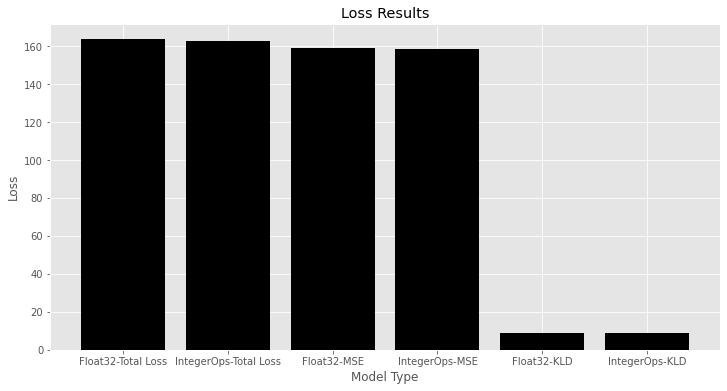

In [ ]:
x = [losses, qi_losses, mses, qi_mses, klds, qi_klds]
y = ['Float32-Total Loss','IntegerOps-Total Loss', 'Float32-MSE','IntegerOps-MSE', 'Float32-KLD','IntegerOps-KLD',]
title = "Loss Results"
x_label = "Model Type"
y_label = "Loss"
    
plot_statistic(x, y, title, x_label, y_label)

In [ ]:
# last one in true_labels not used
accuracy_score      = sklearn.metrics.accuracy_score(true_labels[:len(pred_labels)], pred_labels)
qi_accuracy_score   = sklearn.metrics.accuracy_score(true_labels[:len(qi_pred_labels)], qi_pred_labels)

recall_score      = sklearn.metrics.recall_score(true_labels[:len(pred_labels)], pred_labels)
qi_recall_score   = sklearn.metrics.recall_score(true_labels[:len(qi_pred_labels)], qi_pred_labels)

precision_score      = sklearn.metrics.precision_score(true_labels[:len(pred_labels)], pred_labels)
qi_precision_score   = sklearn.metrics.precision_score(true_labels[:len(qi_pred_labels)], qi_pred_labels)

print('Validation accuracy results are below.\n')

simple_table(
    data_multilist = [[accuracy_score, precision_score, recall_score] ,
                      [qi_accuracy_score, qi_precision_score, qi_recall_score]],
    x_label_list = ["Accuracy", "Precision", "Recall"],
    y_label_list = ["Float32 ", "IntegerOps"]
)

Validation accuracy results are below.

		Accuracy	Precision	Recall
Float32 	0.991033	0.731148	0.867704
IntegerOps	0.990956	0.727273	0.871595


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true_labels[:len(pred_labels)], pred_labels), confusion_matrix(true_labels[:len(qi_pred_labels)], qi_pred_labels)

(array([[12598,    82],
        [   34,   223]]),
 array([[12596,    84],
        [   33,   224]]))

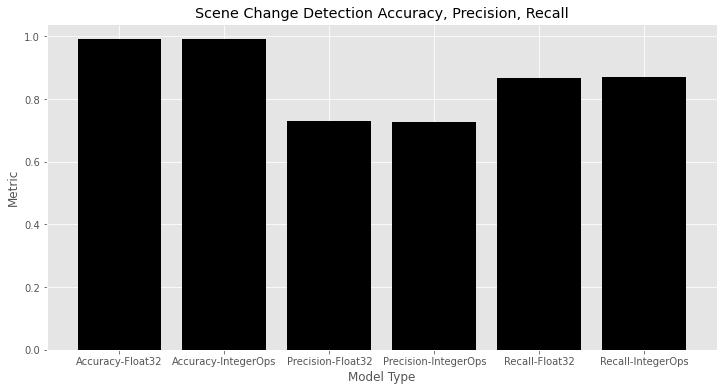

In [ ]:
x = [accuracy_score, qi_accuracy_score, precision_score, qi_precision_score, recall_score, qi_recall_score]
y = ['Accuracy-Float32','Accuracy-IntegerOps', 'Precision-Float32','Precision-IntegerOps', 'Recall-Float32','Recall-IntegerOps']
title = "Scene Change Detection Accuracy, Precision, Recall"
x_label = "Model Type"
y_label = "Metric"
    
plot_statistic(x, y, title, x_label, y_label)

In [ ]:
print('Model sizes are below.\n')

simple_table(
    data_multilist = [[onnx_size_mb] ,
                      [qi_onnx_size_mb]],
    x_label_list = ["Baseline"],
    y_label_list = ["Float32 ", "IntegerOps"]
)

Model sizes are below.

		Baseline
Float32 	9.461112
IntegerOps	3.583965


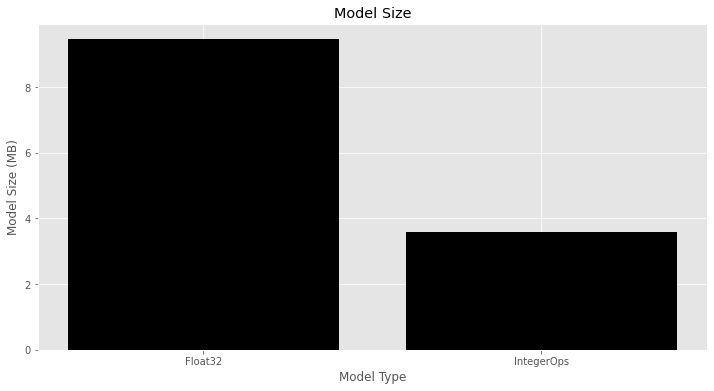

In [ ]:
x = [onnx_size_mb, qi_onnx_size_mb]
y = ['Float32', 'IntegerOps']
title = "Model Size"
x_label = "Model Type"
y_label = "Model Size (MB)"
    
plot_statistic(x, y, title, x_label, y_label)

In [ ]:
print('Validation latency results are below.\n')

simple_table(
    data_multilist = [[total_latency   , total_encoder_time, total_decoder_time],
                      [qi_total_latency, qi_total_encoder_time, qi_total_decoder_time]], 
    x_label_list = ["Total Latency", "Encoder Latency", "Decoder Latency"], 
    y_label_list = ["Float32 ", "IntegerOps"]
)

Validation latency results are below.

		Total Latency	Encoder Latency	Decoder Latency
Float32 	31.319511	4.817760	30.989473
IntegerOps	35.455688	12.049562	30.527119


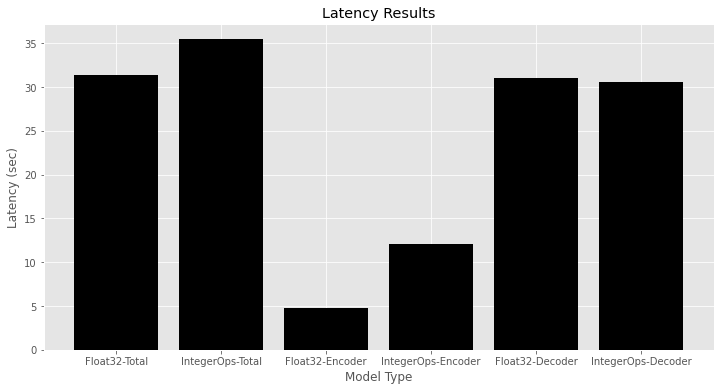

In [ ]:
x = [total_latency, qi_total_latency, total_encoder_time, qi_total_encoder_time, total_decoder_time, qi_total_decoder_time]
y = ['Float32-Total', 'IntegerOps-Total', 'Float32-Encoder', 'IntegerOps-Encoder', 'Float32-Decoder', 'IntegerOps-Decoder',]
title = "Latency Results"
x_label = "Model Type"
y_label = "Latency (sec)"

plot_statistic(x, y, title, x_label, y_label)